In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.CovidDatasets import CDSDataset, JHUDataset
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [131]:
Dataset = JHUDataset()

def model_state(country, state, interventions=None):
   
    ## Constants
    start_time = time.time()
    HOSPITALIZATION_RATE = .0727
    HOSPITALIZED_CASES_REQUIRING_ICU_CARE = .1397
    TOTAL_INFECTED_PERIOD = 12
    MODEL_INTERVAL = 4
    r0 = 3.2
    POP = Dataset.get_population_by_country_state(country, state)
    # Pack all of the assumptions and parameters into a dict that can be passed into the model
    MODEL_PARAMETERS = {
        # Pack the changeable model parameters
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),
        'population': POP,
        #'projection_iterations': 25, # Number of iterations into the future to project
        'projection_iterations': 60, # Number of iterations into the future to project
        'r0': r0,
        'interventions': interventions,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        # Assumes that anyone who needs ICU care and doesn't get it dies
        'case_fatality_rate_hospitals_overwhelmed': HOSPITALIZATION_RATE * HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,
        'model_interval': 4, # In days
        'total_infected_period': 12, # In days
        'rolling_intervals_for_current_infected': int(round(TOTAL_INFECTED_PERIOD / MODEL_INTERVAL, 0)),
        'estimated_new_cases_per_death': 32,
        'estimated_new_cases_per_confirmed': 20,
        # added for seird model
        #'incubation_period': 5, # In days
        'use_harvard_init': use_harvard_init, #If True use the harvard model inputs for inital conditions and N (recreate their graph)

        
        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': False, #If True use the parameters that make R0 2.4, if not calculate off the above
        'hospitalization_rate': HOSPITALIZATION_RATE,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'total_infected_period': 12, # In days
        'duration_mild_infections': 6, # In days
        'hospital_time_recovery': 11, #Duration of hospitalization, In days
        'icu_time_death': 7, #Time from ICU admission to death, In days
        'case_fatality_rate': .0109341104294479,
        'beta': 0.5,
        'beta_hospitalized': 0.1,
        'beta_icu': 0.1,
        'presymptomatic_period': 3,
        'exposed_from_infected': True,

        #'model': 'sir',
        'model': 'seir',
    }
    
    MODEL_PARAMETERS['exposed_infected_ratio'] = 1/MODEL_PARAMETERS['beta']

    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

r0 = 2.4

INTERVENTIONS = [
    None, 
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): 3.087079333
    },
    {
        datetime.date(2020, 3, 23): 1.7,
        datetime.date(2020, 6, 23): 3.087079333
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.3,
        datetime.date(2020, 4, 28): 0.2,
        datetime.date(2020, 5,  6): 0.1,
        datetime.date(2020, 5, 10): 0.035,
        datetime.date(2020, 5, 18): 3.087079333
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.01,
        datetime.date(2020, 4, 28): 0.0,
        datetime.date(2020, 5,  6): 0.01,
        datetime.date(2020, 5, 10): 0.035,
        datetime.date(2020, 8, 29): 3.087079333
    },    
    {
        datetime.date(2020, 4, 3): 1.3,
        datetime.date(2020, 5, 18): 3.087079333

    },
    {
        datetime.date(2020, 3, 3): 5,
    },
]

In [95]:
#JHUDataset.get_timeseries_by_country_state('USA', 'TX', 1) #[['date','cases','deaths','recovered','active']]
#Dataset.get_beds_by_country_state('USA', 'NY')

In [96]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]

    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))

    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    #df_plt.set_xticklabels(labels=x_dates, rotation=45, ha='right')

    return(df_plt)

In [99]:
# Params with True
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 1000

# params with False
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 28995881.0

In [100]:
use_harvard_init = False #If True use the harvard model inputs for inital conditions and N (recreate their graph)
#use_harvard_init = True #If True use the harvard model inputs for inital conditions and N (recreate their graph)

{"beta": [0, 1.7243828528610667e-08, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.3333333333333333, "gamma": [0, 0.15455, 0.07820909090909091, -0.010942242112556844], "rho": [0, 0.012116666666666664, 0.0127], "mu": 0.1537993849696997}
3.087079333
date           2020-11-20 00:00:00
total                     28995881
susceptible             1562640.11
exposed                       0.02
infected                      0.53
infected_a                    0.07
infected_b                    0.37
infected_c                    0.09
recovered              27133413.79
dead                     299826.56
beds                         66691
Name: 262, dtype: object


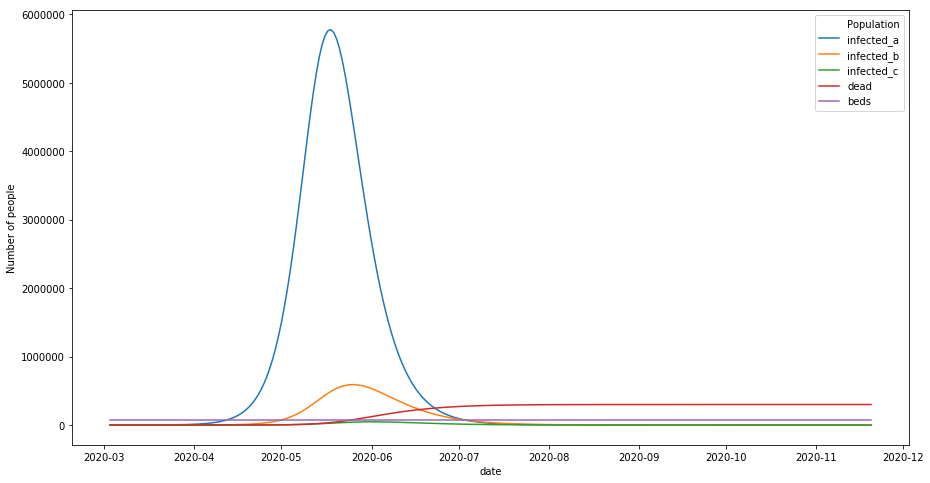

In [136]:
[initervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

print(initervention_df.iloc[-1])
#print(initervention_df.iloc[-20])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(initervention_df, chart_cols)

{"beta": [0.0, 6.971713059633818e-09, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.3333333333333333, "gamma": [0, 0.15455, 0.07820909090909091, -0.010942242112556844], "rho": [0, 0.012116666666666664, 0.0127], "mu": 0.1537993849696997}
1.2999851064597285
date           2020-11-20 00:00:00
dead                     299653.31
exposed                      17.75
infected                    519.41
infected_a                   86.51
infected_b                  353.22
infected_c                   79.68
recovered              27130396.90
susceptible             1565293.63
total                     28995881
beds                         66691
Name: 267, dtype: object


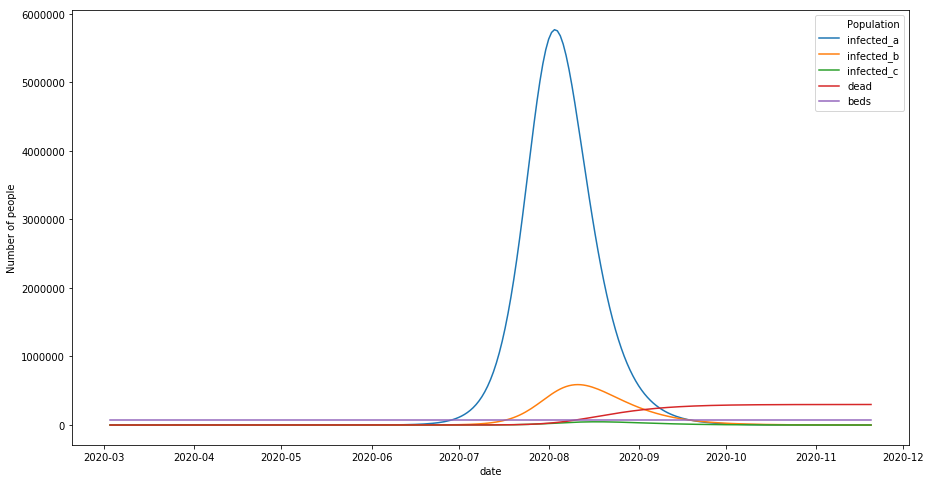

In [137]:
[initervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[3])

print(initervention_df.iloc[-1])
#print(initervention_df.iloc[-20])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(initervention_df, chart_cols)

In [13]:
#initervention_df.describe()

In [138]:
print(initervention_df.loc[160:].head(50))

          date      dead    exposed   infected  infected_a  infected_b  \
160 2020-08-05  43270.07 2547053.23 6235919.31  5679008.30   525718.51   
161 2020-08-06  48236.73 2344551.93 6135930.87  5557408.06   545140.23   
162 2020-08-07  53534.32 2139472.42 5988432.09  5391740.78   561200.48   
163 2020-08-08  59147.92 1937258.32 5800074.42  5188866.58   573720.67   
164 2020-08-09  65058.17 1742229.82 5578052.37  4956088.14   582620.20   
165 2020-08-10  71241.69 1557578.12 5329681.88  4700734.21   587910.58   
166 2020-08-11  77671.68 1385449.42 5062051.94  4429820.33   589685.65   
167 2020-08-12  84318.50 1227083.92 4781760.77  4149797.06   588109.24   
168 2020-08-13  91150.38 1082980.35 4494736.53  3866384.13   583401.47   
169 2020-08-14  98134.09  953063.24 4206134.41  3584481.56   575824.80   
170 2020-08-15 105235.62  836837.93 3920297.60  3308144.07   565670.70   
171 2020-08-16 112420.80  733525.02 3640767.55  3040603.98   553247.35   
172 2020-08-17 119655.87  642170.51 33

{"beta": [0.0, 6.971713059633818e-09, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 1.0, "gamma": [0, 0.15455, 0.07820909090909091, -0.010942242112556844], "rho": [0, 0.012116666666666664, 0.0127], "mu": 0.1537993849696997}
1.2999851064597285
date           2020-11-20 00:00:00
dead                     296058.76
exposed                       0.01
infected                      1.51
infected_a                    0.19
infected_b                    1.07
infected_c                    0.25
recovered              26796434.48
susceptible             1903386.23
total                     28995881
beds                         66691
Name: 264, dtype: object


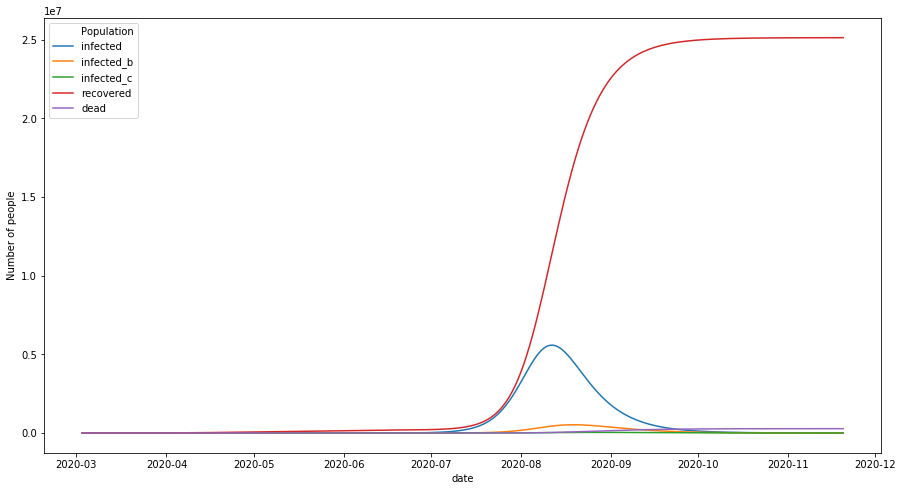

In [15]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[1])
    
print(initervention_df.iloc[-1])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
#chart_cols = ["infected", "infected_b", "infected_c",  "dead"] #, "susceptible"]
plot_df(df, chart_cols)

[1.20518064e+07 7.23077629e+07 9.63232006e+06 8.55691933e+05
 2.31194804e+09 2.32811500e+07]
(365, 6)


(1, 28995881.0)

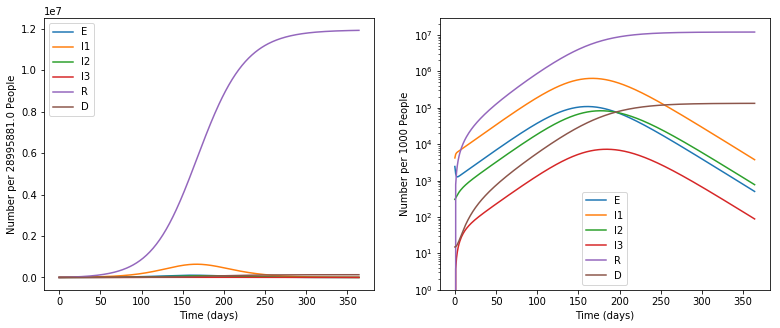

In [16]:
if use_harvard_init:
    tmax=365
    N = 1000
    tvec=np.arange(0,tmax,0.1)
else:
    # tmax = 80 * 4
    tmax = 365
    N =  28995881.00
    #N = 10000
    tvec=np.arange(0,tmax,1)
    
#print(np.array(N-np.sum(soln,axis=1,keepdims=True)))
#s = [N-np.sum(soln,axis=1,keepdims=True)]
#s = np.max(s,0)
soln_plt = np.hstack([soln])
#soln_plt = np.hstack(soln)

print(sum(soln_plt))
print(soln_plt.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,soln_plt)
plt.xlabel("Time (days)")
plt.ylabel(f"Number per {str(N)} People")
#plt.legend(("S","E","I1","I2","I3","R","D"))
plt.legend(("E","I1","I2","I3","R","D"))

#plt.ylim([0,N])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,soln_plt)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
#plt.legend(("S","E","I1","I2","I3","R","D"))
plt.legend(("E","I1","I2","I3","R","D"))

plt.ylim([1,N])
#plt.tight_layout()